<a href="https://colab.research.google.com/github/dla9944/2023_God_damn_deeplearning/blob/master/CRNN_TEST2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn, optim
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import save_image
import torchsummary
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

import numpy as np
import pandas as pd
import glob

import string

In [2]:
# gpu 사용

USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


In [3]:
from google.colab import files
!pip install -q kaggle #kaggle 설치 # --quiet
# -- kaggle api를 사용하기 위한 인증파일을 설정 (8-11)
files.upload() #kaggle API file upload
!mkdir ~/.kaggle # kaggle 디렉토리 생성 / mkdir : make directory - 폴더 생성 (~)
!cp kaggle.json ~/.kaggle/ #kaggle.json 파일 kaggle 폴더에 복사 / cp a b (copy)
!chmod 600 ~/.kaggle/kaggle.json # 권한 변경 r w x (4 2 1)
# ---------
# !kaggle datasets list #kaggle 데이터셋 리스트 체크
# https://www.kaggle.com/datasets/fournierp/captcha-version-2-images
# ... > Copy API command
!kaggle datasets download -d fournierp/captcha-version-2-images

mkdir: cannot create directory ‘/root/.kaggle’: File exists
captcha-version-2-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/captcha-version-2-images.zip

Archive:  /content/captcha-version-2-images.zip
replace samples/226md.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace samples/22d5n.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
imgfile = sorted(glob.glob(
    'samples/*.png'
))
imgfile_1 = imgfile[1]

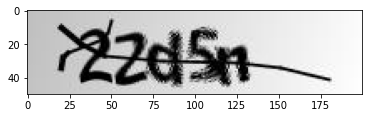

In [6]:
plt.imshow(Image.open(imgfile_1))

In [7]:
# get BOW 함수
def get_BOW(corpus):
    BOW = {'<pad>' : 0}
    for letter in corpus:
        if letter not in BOW.keys():
            BOW[letter] = len(BOW.keys())
    return BOW

In [41]:
# Captcha 데이터셋

class Captcha(Dataset):
   def __init__(self, path, train = True):
       super().__init__()
       self.corpus = string.ascii_lowercase + string.digits

       self.BOW = get_BOW(self.corpus)
       self.imgfiles = sorted(glob.glob(path+'/*.png'))
       self.train = train
       self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
       self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]

   def get_seq(self, line):
       label = []
       for letter in line:
           label.append(self.BOW[letter])
       return label

   def __len__(self):
       if self.train:
          return len(self.trainset)
       else:
          return len(self.testset)

   def __getitem__(self, i):
       if self.train:
          data = Image.open(self.trainset[i]).convert('RGB')
          label = self.trainset[i].split('/')[-1]
          label = label.replace(".png","")
          label = self.get_seq(label)
          data = np.array(data).astype(np.float32)
          data = np.transpose(data, (2, 0, 1))
          label = np.array(label)
          return data, label
       else:
          data = Image.open(self.testset[i]).convert('RGB')
          label = self.testset[i].split("/")[-1]
          label = label.replace(".png","")
          label = self.get_seq(label)
          data = np.array(data).astype(np.float32)
          label = np.array(label)
          return data, label

In [42]:
# 기본 블럭
class BasicBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size = (3,5), stride = (2,1)):
       super(BasicBlock, self).__init__()

       self.c1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                           kernel_size = kernel_size, stride = stride)
       self.c2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels,
                           kernel_size = (3,3), padding = 1)
       self.downsample = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                           kernel_size = kernel_size, stride = stride)
       self.bn1 = nn.BatchNorm2d(num_features = out_channels)
       self.bn2 = nn.BatchNorm2d(num_features = out_channels)
       self.relu = nn.ReLU()
   def forward(self, x):
       x_ = x
       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       x_ = self.downsample(x_)
       x += x_
       x = self.relu(x)

       return x      

In [43]:
torchsummary.summary(BasicBlock(16, 5).to(device), (16, 200, 50), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 5, 99, 46]           1,205
       BatchNorm2d-2            [16, 5, 99, 46]              10
              ReLU-3            [16, 5, 99, 46]               0
            Conv2d-4            [16, 5, 99, 46]             230
       BatchNorm2d-5            [16, 5, 99, 46]              10
            Conv2d-6            [16, 5, 99, 46]           1,205
              ReLU-7            [16, 5, 99, 46]               0
Total params: 2,660
Trainable params: 2,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 9.77
Forward/backward pass size (MB): 19.46
Params size (MB): 0.01
Estimated Total Size (MB): 29.23
----------------------------------------------------------------


In [44]:
class CRNN(nn.Module):
   def __init__(self, output_size) -> None:
       super(CRNN, self).__init__()
       self.c1 = BasicBlock(in_channels=3, out_channels = 64)  
       self.c2 = BasicBlock(in_channels=64, out_channels = 64)  
       self.c3 = BasicBlock(in_channels=64, out_channels = 64)  
       self.c4 = BasicBlock(in_channels=64, out_channels = 64) 
       self.c5 = nn.Conv2d(64, 64, kernel_size = (2, 5))
       self.gru = nn.GRU(64, 64, batch_first = False)   
       self.fc1 = nn.Linear(in_features = 64, out_features = 128)
       self.fc2 = nn.Linear(in_features = 128, out_features = output_size)
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.c1(x)
       x = self.c2(x)
       x = self.c3(x)
       x = self.c4(x)
       x = self.c5(x)
       x = x.view(x.shape[0], 64, -1)
       x = x.permute(2, 0, 1)
       x, _ = self.gru(x)
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = F.log_softmax(x, dim = -1)
       return x

In [45]:
from tqdm.notebook import tqdm
from torch.optim.adam import Adam
from torch.optim.adamw import AdamW

In [46]:
dataset = Captcha(path='samples/')
print(len(dataset.BOW))
loader = DataLoader(dataset, batch_size=8)

model = CRNN(output_size=len(dataset.BOW)).to(device)
optim = Adam(model.parameters(), lr=0.0001)

37


In [47]:
torchsummary.summary(model, (3, 50, 200), 8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 64, 24, 196]           2,944
       BatchNorm2d-2           [8, 64, 24, 196]             128
              ReLU-3           [8, 64, 24, 196]               0
            Conv2d-4           [8, 64, 24, 196]          36,928
       BatchNorm2d-5           [8, 64, 24, 196]             128
            Conv2d-6           [8, 64, 24, 196]           2,944
              ReLU-7           [8, 64, 24, 196]               0
        BasicBlock-8           [8, 64, 24, 196]               0
            Conv2d-9           [8, 64, 11, 192]          61,504
      BatchNorm2d-10           [8, 64, 11, 192]             128
             ReLU-11           [8, 64, 11, 192]               0
           Conv2d-12           [8, 64, 11, 192]          36,928
      BatchNorm2d-13           [8, 64, 11, 192]             128
           Conv2d-14           [8, 64, 

In [48]:
# epoch 시작 30회
for epoch in range(1,31):
    iterator = tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()
        preds = model(data.to(device)) 
        preds_size = torch.IntTensor([preds.size(0)] * 8).to(device)
        target_len = torch.IntTensor([len(txt) for txt in label]).to(device)
        loss = nn.CTCLoss(blank=0)(preds, label.to(device), preds_size, target_len)
        loss.backward()
        optim.step()
        iterator.set_description(f"epoch 횟수 : {epoch} loss :{loss.item()}")

torch.save(model.state_dict(), 'CRNN_EPOCH_30회.pt')

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

# 글자가 선명하지 않은 경우

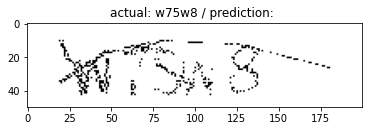

In [49]:
model.load_state_dict(torch.load("CRNN_EPOCH_30회.pt", map_location=device))

with torch.no_grad():

   testset = Captcha(path='samples/', train=False)
   idx = 77 #@param {"type":"number"}
#    idx = 0
   test_img, label = testset[idx] # 50, 200, 3
   input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0) # 1, 50, 200, 3
   input_tensor = input_tensor.permute(0, 3, 1, 2).to(device) # 1, 3, 50, 200

   # 가장 높은 확률을 갖는 글자를 추출
   output = model(input_tensor)
#    print(output)
   pred = torch.argmax(output, dim=-1) # -1 => 가장 안쪽 차원에서 가장 높은 값의 index
   # -> [[고유번호들의 배열]]
#    print(pred)

   # 글자 간의 중복을 제거
   # 하나의 글자를 나타내는 데 여러 픽셀이 이용되기 때문에 글자의 중복이 발생
   # 예를 들어 hhh-eell-ll-o와 같이 신경망이 예측했다면
   # -(글자가 없는 공백)이 나오기 전까지, 혹은 다른 글자가 나오기 전까지 겹치는 글자는 중복
   prev_letter = pred[0].item() # 스칼라
   pred_word = ""
   for letter in pred:
       if letter.item() != 0 and letter.item() != prev_letter: # 0은 공백
           pred_word += list(testset.BOW.keys())[letter.item()]
       prev_letter = letter.item()

   plt.imshow(test_img)
   plt.title("actual: "+ "".join([list(testset.BOW.keys())[l.item()] for l in label]) + " / prediction: "+ pred_word)
   plt.show()